In [422]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [423]:
window = 25
stride = 3

In [424]:
def find_vertices(img, kernel, stride):

    # Pad image to be divisible by stride
    while img.shape[0] % stride != 0:
        img = cv2.copyMakeBorder(img, 0, 1, 0, 0, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    while img.shape[1] % stride != 0:
        img = cv2.copyMakeBorder(img, 0, 0, 0, 1, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    # Padding for sliding window
    pad = int(kernel//2)+1
    img = cv2.copyMakeBorder(img, pad, pad, pad, pad, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    x_strides = int(img.shape[1]/stride) - 2*pad
    y_strides = int(img.shape[0]/stride) - 2*pad
    print(f"x strides:{x_strides}, y strides:{y_strides}")

    # Circular Mask
    radius = pad
    mask = np.zeros((kernel, kernel))
    center = kernel // 2
    for i in range(kernel):
        for j in range(kernel):
            y, x = i - center, j - center  # Coordinates relative to the circle's center
            if x**2 + y**2 <= radius**2:
                mask[i, j] = 1

    # Initialize variables
    knots = []
    win_x_beg = 0
    win_y_beg = 0
    win_x_end = kernel
    win_y_end = kernel

    for ii in range(x_strides):
        for jj in range(y_strides):

            #Circular window
            square_win = img[win_x_beg:win_x_end, win_y_beg:win_y_end]
            circle_win = np.where(mask, square_win, np.nan)#square_win * mask

            # Find vertices based on average value in circular window
            if 150 > np.nanmean(circle_win) > 100:
                knots.append((win_y_beg+pad, win_x_beg+pad))

            # Find vertices based on average value in square window
            # if 150 > np.mean(img[win_x_beg:win_x_end, win_y_beg:win_y_end]) > 100:
            #     knots.append((win_y_beg+pad, win_x_beg+pad))

            # Find contours in the window_region
            # window_region = img[win_x_beg:win_x_end, win_y_beg:win_y_end]
            # contours, hierarchy = cv2.findContours(window_region, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            # if len(contours) == 5:
            #     knots.append((win_y_beg+pad, win_x_beg+pad))
            
            # Increment row
            win_y_beg += stride
            win_y_end += stride
        
        # Increment column
        win_x_beg += stride
        win_x_end += stride

        # Reset row values
        win_y_beg = 0
        win_y_end = kernel

    return img, knots

In [425]:
src = cv2.imread('test_sequence/image2.png', cv2.IMREAD_GRAYSCALE)
_, src = cv2.threshold(src, 10, 255, cv2.THRESH_BINARY)

In [426]:
np.max(src)

255

In [427]:
resized_img, vertices = find_vertices(src, window, stride)
resized_img.shape

x strides:663, y strides:664


(2072, 2069)

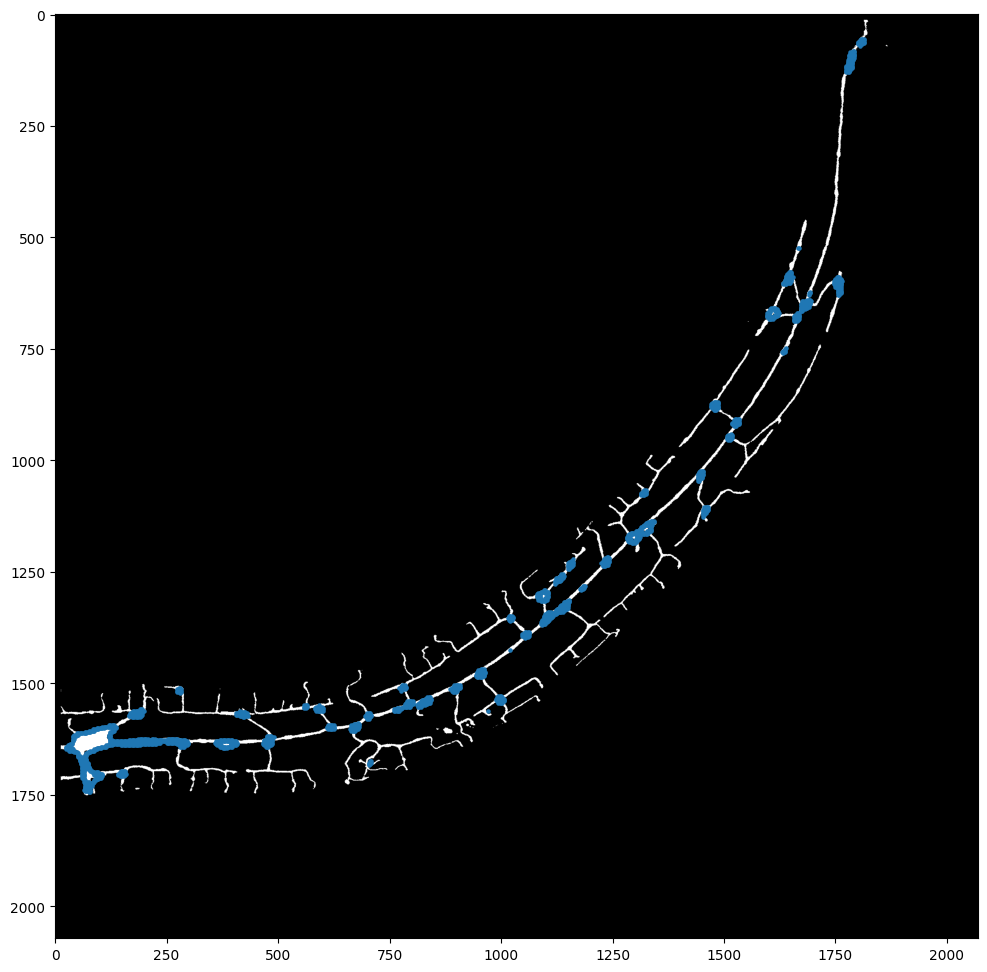

In [428]:
# Plot Vertices on image
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(resized_img, cmap='gray')
ax.scatter(*zip(*vertices), s=5)